In [1]:
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy.stats import linregress
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def missing_vals(df):
    null_vals = df.isnull().sum(axis=0)
    null_vals = null_vals[null_vals > 0].sort_values(ascending=False).rename('count')
    null_perc = null_vals / df.shape[0] * 100
    null_perc.name = 'percent'
    return pd.concat([null_vals, null_perc], axis=1)

def do_loop(idx1, idx2, msg):
    for i in idx1:
        is_missing = True
        for j in idx2:
            if i == j:
                is_missing = False
                break
        if is_missing:
            print(msg.format(i))

def compare_feature_keys(keys, columns):
    print("Keys missing in description")
    do_loop(columns, keys, "  - Missing key {} in description")
    print("Keys missing in description")
    do_loop(keys, columns, "  - Missing key {} in data set")

def gen_cat_matrix(df, x, y, fill=0, color='tab:blue', **kwargs):
    tmp = df.groupby([x, y])[y].value_counts().reset_index()
    pivot = pd.pivot_table(data=tmp, index=x, columns=y, values='count').fillna(fill)
    linewidth = kwargs.pop('linewidth', 0.9)
    sns.heatmap(pivot, annot=True, fmt='.0f', linecolor=color,
                linewidth=linewidth)

def fill_mode(sr):
    mode = sr.dropna().agg(pd.Series.mode)
    return sr.fillna(mode[0])

def replace_price_ticks(ax, xaxis):
    ticks = np.arange(0, 9e5, 1e5)
    labels = [str(int(round(t/1e3,0))) for t in ticks]
    if xaxis:
        ax.set_xticks(ticks, labels)
        ax.set_xlabel('Price / 10$^3\\times$USD')
    else:
        ax.set_yticks(ticks, labels)
        ax.set_ylabel('Price / 10$^3\\times$USD')
        
def gen_lotfront_plot(df, group_cols):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    tmp = df.copy()
    sns.scatterplot(y='LotFrontage', x='SalePrice', data=tmp, ax=ax1)
    tmp['LotFrontage'] = tmp.groupby(group_cols)['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
    print('Missing values after average: {}'.format(tmp['LotFrontage'].isnull().sum()))
    idxs = df['LotFrontage'].isnull()
    sns.scatterplot(y='LotFrontage', x='SalePrice', data=tmp.loc[idxs], ax=ax1)
    replace_price_ticks(ax1, True)
    ax1.legend(labels=['Original', 'New values'])
    ax1.set_title('Using average', fontsize=20)
    tmp = df.copy()
    sns.scatterplot(y='LotFrontage', x='SalePrice', data=tmp, ax=ax2)
    tmp['LotFrontage'] = tmp.groupby(group_cols)['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    print('Missing values after median: {}'.format(tmp['LotFrontage'].isnull().sum()))
    idxs = df['LotFrontage'].isnull()
    sns.scatterplot(y='LotFrontage', x='SalePrice', data=tmp.loc[idxs], ax=ax2)
    replace_price_ticks(ax2, True)
    ax2.legend(labels=['Original', 'New values'])
    ax2.set_title('Using median', fontsize=20)

In [3]:
with open(os.path.join('data', 'data_description.txt'), 'r') as fn:
    lines = fn.readlines()
i = 0
keys = {}
contents = {}
while i < len(lines):
    line = lines[i]
    if ':' in line and not line.startswith('  '):
        key, descrip = line.split(':')
        keys[key] = descrip
        if lines[i+2].startswith('  '):
            i += 2
            contents[key] = []
            while lines[i].strip():
                contents[key].append(lines[i].strip())
                i += 1
                if i >= len(lines): break
            contents[key] = '<br>'.join(contents[key])
        else:
            contents[key] = 'No categories'
    i += 1

## Studying data

Looking at the first few rows of the data after reading it.

In [4]:
dtypes = dict(MSSubClass=str)

In [5]:
df_train = pd.read_csv(os.path.join('data', 'train.csv'), index_col=0, dtype=dtypes)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Checking for any missing values in the original data set

In [7]:
missing_vals(df_train)

,count,percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


### Making sure that there is a description for every available feature column

The column `'SalePrice'` is expected as this is the label we are trying to predict.
It is not a feature in the data set.

In [9]:
compare_feature_keys(keys.keys(), df_train.columns)

Keys missing in description
  - Missing key SalePrice in description
Keys missing in description


# Data Preprocessing

Now that I know there are missing values in the data set `'train.csv'` I will go ahead
and sort out what to do with those missing values.

For the sake of brevity when I come to filling in missing data and imputing values based
on other columns I will just be using the data from this single imputation. I am aware
that it is often better to consider multiple imputations and to run a model for each of
those methods as this can give a better performing model for unobserved data that may
not fit the trends in the imputation.

In [11]:
df = df_train.copy()

## Outliers

Text(0.5, 0, 'Price / 10$^3\\times$USD')

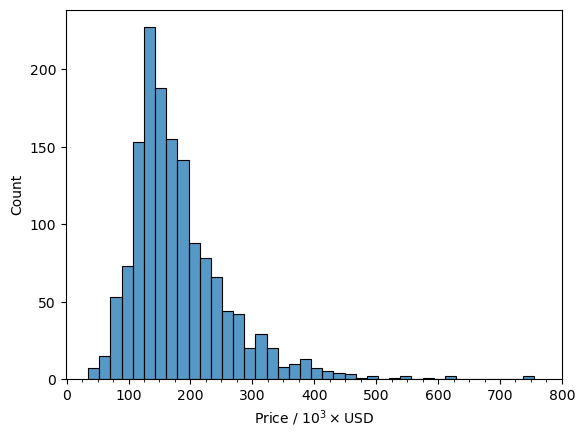

In [12]:
fig, ax = plt.subplots()
sns.histplot(data=df, x='SalePrice', bins=40, ax=ax)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2.5e4))
ticks = np.arange(0, 9e5, 1e5)
labels = [str(int(round(t/1e3,0))) for t in ticks]
ax.set_xticks(ticks, labels)
ax.set_xlabel('Price / 10$^3\\times$USD')

We can clearly see that there are a few possible outliers in the higher regions
above 700 thousand USD. Let's take a look at the correlation matrix values and
see if we can determine anything based on those values.

In [13]:
df.corr(numeric_only=True)['SalePrice'].sort_values(key=abs, ascending=False).head(12)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
Name: SalePrice, dtype: float64

Text(0.5, 0, 'Overall quality of home')

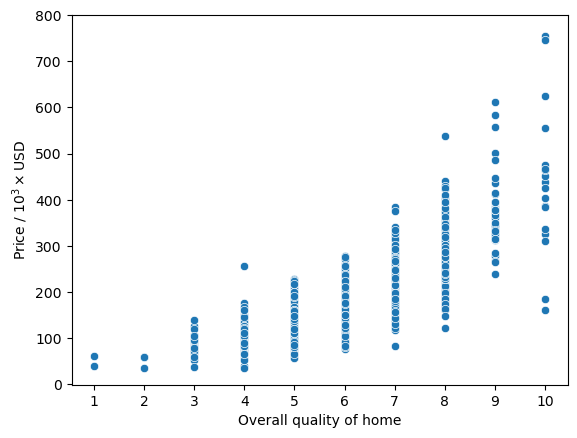

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(y='SalePrice', x='OverallQual', data=df, ax=ax)
replace_price_ticks(ax, False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Overall quality of home')

Here, we can actually see a pretty good relationship between the price of a home and
the overall quality. However, we can also see that there are a couple houses that have
an overall quality rating of 10 and a price less than 200 thousand USD. Let's look
at another plot with the `'GrLivArea'` which is the Above ground living area.

Text(0.5, 0, 'Living Area / ft$^2$')

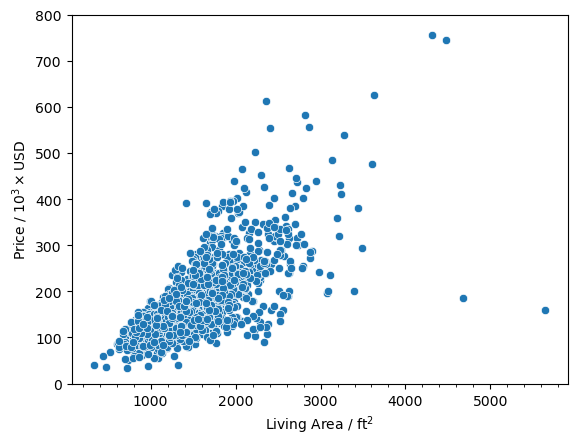

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(y='SalePrice', x='GrLivArea', data=df, ax=ax)
replace_price_ticks(ax, False)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200))
ax.set_xlabel('Living Area / ft$^2$')

So now let's look at the data points and see if they are the same.

In [16]:
df.loc[(df['OverallQual'] == 10) & (df['SalePrice'] < 200e3)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [17]:
df.loc[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 200e3)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


And we can see that they are the same data points. I am labeling these as outlier points since
they don't fall nicely within the overall trend that we can see for `'OverallQual'` and
`'GrLivArea'`. The values that we initially found to be above 700 thousand USD are not outliers
because they actually fall within the trends. They are just on the expensive end of the
spectrum so they will give us valuable information for the model.

In [18]:
idxs = df.loc[(df['OverallQual'] == 10) & (df['SalePrice'] < 200e3)].index
df.drop(idxs, axis=0, inplace=True)

Text(0.5, 0, 'Living Area / ft$^2$')

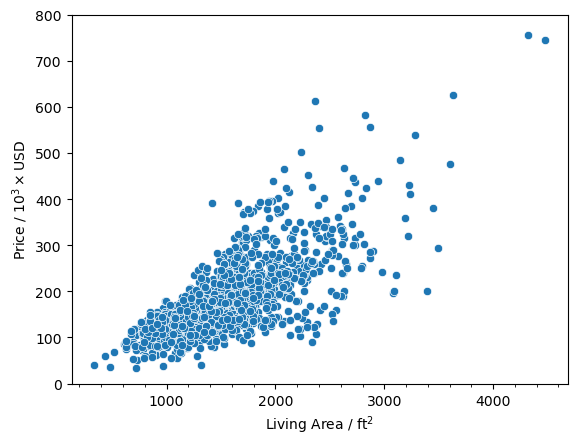

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(y='SalePrice', x='GrLivArea', data=df, ax=ax)
replace_price_ticks(ax, False)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200))
ax.set_xlabel('Living Area / ft$^2$')

In [20]:
df.corr(numeric_only=True)['SalePrice'].sort_values(key=abs, ascending=False).head(8)

SalePrice      1.000000
OverallQual    0.795774
GrLivArea      0.734968
TotalBsmtSF    0.651153
GarageCars     0.641047
1stFlrSF       0.631530
GarageArea     0.629217
FullBath       0.562165
Name: SalePrice, dtype: float64

Now we have a nicely defined linear trend for the sale price with respect to the
living area. We can also see that the correlation values went up slightly for
`'OverallQual'` and `'GrLivArea'`.

## Electrical

First thing I want to determine is if there are any rows that I can simply drop because
getting the values for the missing data might just not make too much sense and I can
simply drop the data point altogether.

So let's look at the number of missing values again.

In [21]:
missing_vals(df)

,count,percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
MasVnrType,872,59.807956
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556


The more curious one to study is the feature column `'Electrical'` as there is only
one missing value that accounts for 0.07% of the availble data. Before I just drop
the row I want to look at the description of it which is

<pre>
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
</pre>

Typically, since there is only one row that is missing data it can be safe enough to
just drop that row entirely as it only accounts for 0.07% of the data set. However,
I want to try to infer the value based on some metric.

First let's look at some of the columns associated with the row that is missing data.
I have identified the dwelling type (`'MSSubClass'`), zoning type (`'MSZoning'`), and
neighborhood (`'Neighborhood'`) as potential columns that may be important in
determining what kind of electrical system the building should have.

In [22]:
df.loc[df['Electrical'].isnull(), ['Electrical', 'MSSubClass', 'MSZoning', 'Neighborhood', 'SalePrice']]

,Electrical,MSSubClass,MSZoning,Neighborhood,SalePrice
Id,,,,,
1380,NaN,80,RL,Timber,167500


Before we do anything let's look at some of the statistics from the sale price
(`'SalePrice'`) with the type of electrical system.

In [23]:
df.groupby('Electrical')['SalePrice'].describe().sort_values(by=['mean'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
Electrical,,,,,,,,
SBrkr,1332.0,186846.810060,79913.027373,37900.0,134500.0,170000.0,221000.00,755000.0
FuseA,94.0,122196.893617,37511.376615,34900.0,98500.0,121250.0,143531.25,239000.0
FuseF,27.0,107675.444444,30636.507376,39300.0,88500.0,115000.0,129950.00,169500.0
FuseP,3.0,97333.333333,34645.827070,73000.0,77500.0,82000.0,109500.00,137000.0
Mix,1.0,67000.000000,NaN,67000.0,67000.0,67000.0,67000.00,67000.0


We can see that the average price is actually the highest with the standard circuit
breakers and romex (`'SBrkr'`). However, you can also see that and electrical system
`'SBrkr'` is actually in over 90% of the homes so it's hard to make any conclusions
on the effect of the electrical system on the final sale price.

Now let's try to take a look at the distributions in the other categorical values.

We start with a Box Plot of the sale prices against the electrical system used.

<Axes: xlabel='SalePrice', ylabel='Electrical'>

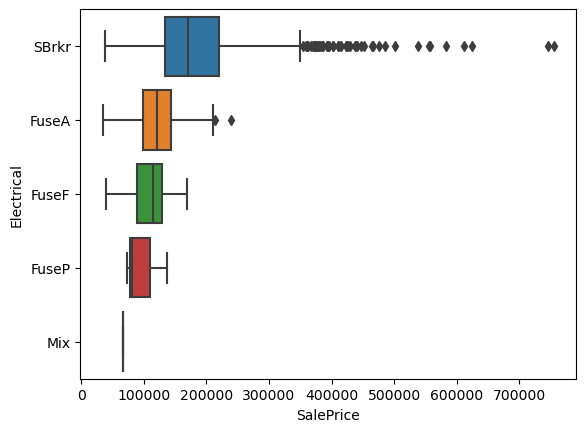

In [24]:
sns.boxplot(x='SalePrice', y='Electrical', data=df,
            order=['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'])

Since this is just a pictorial representation of the statistical data, the overall
conclusions are the same. However, we can see that the median of the data for
`'SBrkr'` is in the lower range of the distribution and there are a lot of points
outside of the $1.5 \times \text{IQR}$ range as defined in Seaborn. While this can,
in some cases, be identified as outliers, this is clearly not that case as the points
are continuous.

Next we have a set of pictorial representations of the
[Pandas pivot table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)
to look at the total number of electrical systems in each of the categorical classifications.
At the end we will break down each of the plots and try to connect them with our data.

We start with the type dwelling.

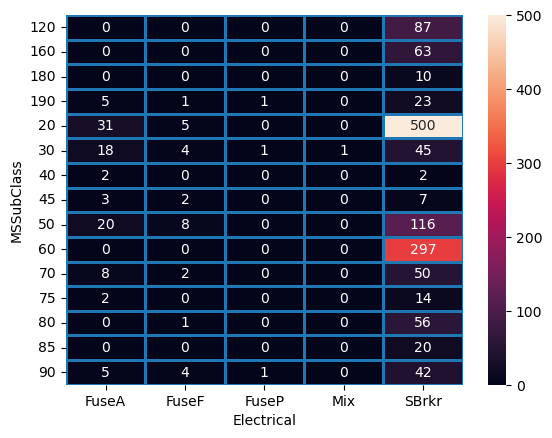

In [25]:
gen_cat_matrix(df=df, x='MSSubClass', y='Electrical')

Next is the zoning type.

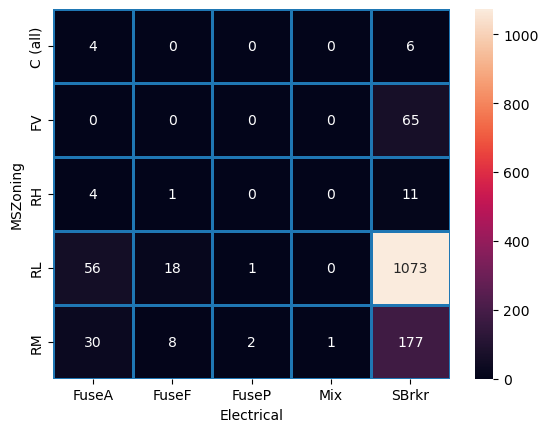

In [26]:
gen_cat_matrix(df=df, x='MSZoning', y='Electrical')

The neighborhood the dwelling is located in.

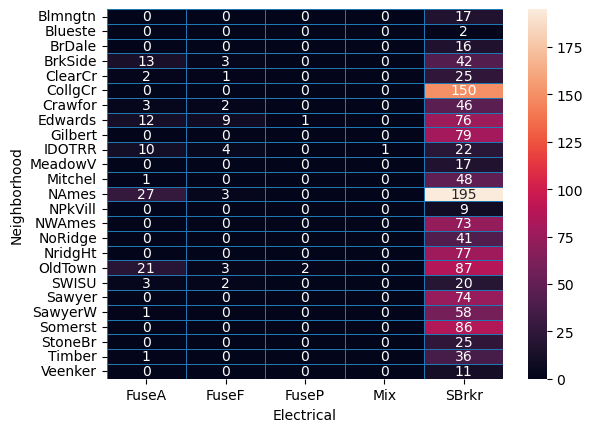

In [27]:
gen_cat_matrix(df=df, x='Neighborhood', y='Electrical', linewidth=0.5)

Based on the plots above I can see that there is no real connection between what
type of electrical system a building has and its location, dwelling type, or
zoning type. They pretty much all have a standard breaker system, `'SBrkr'`.
With this in mind I believe that it is safe to perfrom a replacement of the
missing value with the mode for the neighborhood the home is located.

The next two are trying to identify any relationship between the zoning type
and the type of dwelling and neighborhood, respectively. I do not believe that
this will give any extra valuable information, however, the North Ames
neighborhood, `'NAmes'`, has the highest number of homes that use an electrcial
system classified as `'FuseA'`. If there were more data points missing, it would
be interesting to see if it would be necessary to consider some kind of
distribution to try to retain the original ratios the same.

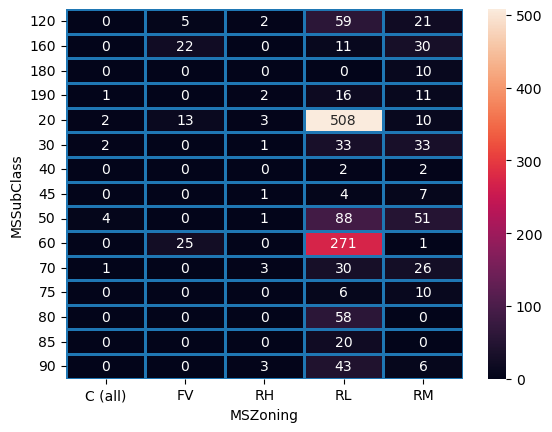

In [28]:
gen_cat_matrix(df=df, x='MSSubClass', y='MSZoning')

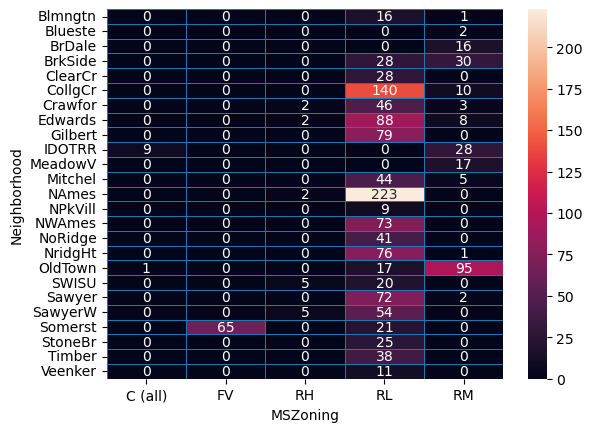

In [29]:
gen_cat_matrix(df=df, x='Neighborhood', y='MSZoning', linewidth=0.5)

So as mentioned before there is no extra information that we will gather from the two plots above.

Now let's make the replacement with the overall mode of the neighborhood the missing value is in.

In [30]:
group_cols = ['Neighborhood', 'MSSubClass', 'MSZoning']
df['Electrical'] = df.groupby(group_cols)['Electrical'].transform(fill_mode)

In [31]:
missing_vals(df)

,count,percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
MasVnrType,872,59.807956
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556


And we have gotten rid of the missing value.

In reality, it might actually be good enough to just drop that row altogether since it
is one row accounting for 0.07% of the data set. However, if there are more values missing,
~40 rows or 2.7%, just dropping the rows might not be the best thing to do. Especially if
we end up doing this for multiple columns that may not share the same indeces.
It can really add up in the end.

## Masonry Veneer

From the previous cell we can see that we are missing values in the `'MasVnrArea'`
and `'MasVnrType'` columns. Below is a description of the columns.

<pre>
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
</pre>

So we can see that it has to do with the masonry veneer that the house has. More
importantly, we can see that for the `'MasVnrType'`, when there is a missing value
it just means that there is no masonry veneer. This can be further supported by
the `'MasVnrArea'`, which is the area covered by the masonry veneer and should be
zero if the `'MasVnrType'` is missing a value. However, we must be careful as the
`'MasVnrArea'` feature is missing some data points. As this is a numerical value
it might be hard to determine what it should be. I will go into this one in more
detail later on.

So let's first take where the values of `'MasVnrType'` is missing a value and
see what are the values of `'MasVnrArea'`.

In [32]:
df.loc[df['MasVnrType'].isnull(), ['MasVnrType', 'MasVnrArea']].value_counts(dropna=False)

MasVnrType  MasVnrArea
NaN         0.0           859
            NaN             8
            1.0             2
            288.0           1
            312.0           1
            344.0           1
Name: count, dtype: int64

What we see is that there are a lot of places
where the `'MasVnrType'` is missing a value **and** `'MasVnrArea'` is 0.0. However, when we
were looking at the percentges of missing values above we could see that the `'MasVnrArea'`
feature was missing values as well and we can see that here.

Therefore, we have to be careful in how we perform the replacement as we must replace the
`NaN` values in `'MasVnrType'` for `'None'` only where `'MasVnrArea'` is 0.0.

In [33]:
df.loc[(df['MasVnrType'].isnull()) & (df['MasVnrArea'] == 0.0), ['MasVnrType']] = 'None'

Now let's try to determine what we should do with the other values in these columns.

In [34]:
df.loc[df['MasVnrType'].isnull(), ['MasVnrType', 'MasVnrArea']].value_counts(dropna=False)

MasVnrType  MasVnrArea
NaN         NaN           8
            1.0           2
            288.0         1
            312.0         1
            344.0         1
Name: count, dtype: int64

Now we are just missing values when `'MasVnrArea'` is either `NaN` or non-zero.

Let's look into the distribution of the values with respect to the sale price.
What I want to determine is how correlated are the values and will some simple
replacements create outliers in our data set.

Text(0.5, 0, 'Sale Price / $')

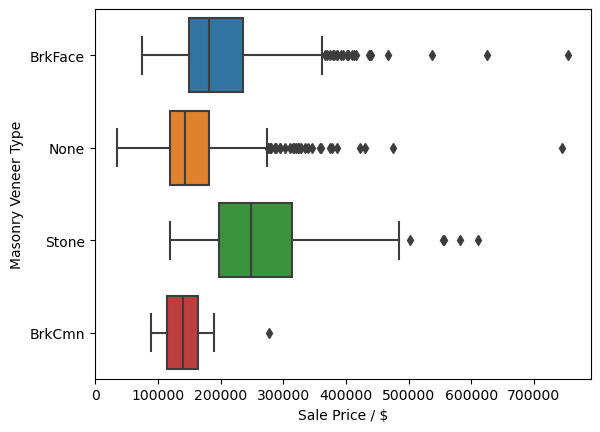

In [35]:
sns.boxplot(x='SalePrice', y='MasVnrType', data=df)
plt.ylabel('Masonry Veneer Type')
plt.xlabel('Sale Price / $')

Text(0.5, 0, 'Sale Price / $')

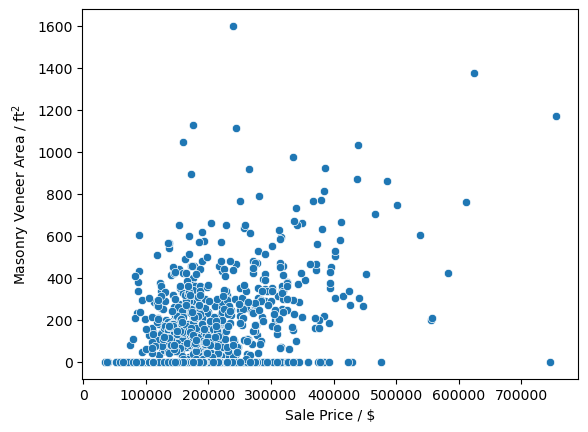

In [36]:
sns.scatterplot(x='SalePrice', y='MasVnrArea', data=df)
plt.ylabel('Masonry Veneer Area / ft$^2$')
plt.xlabel('Sale Price / $')

There does not seem to ba a very large correlation between the type of masonry
veneer or its type on the sale price of a home. Due to this I will go ahead and
replace all `NaN` values with 0.0 and `'None'` in the `'MasVnrArea'` and
`'MasVnrType'`, respectively. Since there is no large correlation between the
values and the sale price I feel confident in also making the replacement
of all the values of `'MasVnrType'` with `'None'`, even when the `'MasVnrArea'`
is not zero.

In [37]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
df['MasVnrType'] = df['MasVnrType'].fillna('None')

In [38]:
missing_vals(df)

,count,percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556
GarageQual,81,5.555556


And now we have no missing values for the `'MasVnrType'` when the `'MasVnrArea'` is zero.

## Basement

The next values that I want to tackle are going to be concerned with the basement data. The
description for all the available feature columns for basements are

<pre>
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (&lt;70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area
</pre>

So, similar to before we can see that a lot of the data that is missing for the basements is
categorical and we can probably fill in a lot of the `NaN` values with `'None'` as there is
probably no basement there.

Let's confirm this below by getting the square footage and other things like we did for the
`'MasVnrType'` feature.

In [39]:
df.loc[df['BsmtCond'].isnull(), [x for x in df.columns if 'bsmt' in x.lower()]].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0           NaN           0           0          0            0             0               37
Name: count, dtype: int64

And we can see that for all the categorical values, if the numerical features,
`'BsmtFinSF1'`, `'BsmtFinSF2'`, `'BsmtUnfSF'`, and `'TotalBsmtSF'`, it is missing
a value, supporting our initial guess. However, looking at the data frame for the
missing values

In [40]:
missing_vals(df).loc[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

,count,percent
BsmtQual,37,2.537723
BsmtCond,37,2.537723
BsmtExposure,38,2.606310
BsmtFinType1,37,2.537723
BsmtFinType2,38,2.606310


Let's go ahead and replace the categorical values for all the columns when `'BsmtCond'`
is `NaN` with `'None'`.

In [41]:
cat_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df.loc[df['BsmtCond'].isnull(), cat_cols] = 'None'

Let's check for missing values.

In [42]:
missing_vals(df)

,count,percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556
GarageQual,81,5.555556


And we still have values missing for the `'BsmtExposure'` and `'BsmtFinType2'` columns.

Below is the data for when the other two columns are missing data.

In [43]:
df.loc[(df['BsmtFinType2'].isnull()) & (~df['BsmtCond'].isnull()), [x for x in df.columns if 'bsmt' in x.lower()]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
333,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,1,0


In [44]:
df.loc[(df['BsmtExposure'].isnull()) & (~df['BsmtCond'].isnull()), [x for x in df.columns if 'bsmt' in x.lower()]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
949,Gd,TA,NaN,Unf,0,Unf,0,936,936,0,0


Well, we can actually see that `'BsmtFinType2'` and `'BsmtExposure'` do not share missing
values on the same row and this data should not actually be missing. Data for `'BsmtFinType2'`
should only be missing when `'BsmtFinType2'` is 0 and `'BsmtExposure'` should only be
missing when there is no basement, i.e. when `'TotalBsmtSF'` is 0. This is somewhat
problematic and will require looking at a few other things before deciding on what should
be done.

So let's take a look at how dependent the sale price, `'SalePrice'`, is to the different
categorical values for the basement in our data set. The y-axis will be labeled from worst
(bottom) to best (top) in terms of quality or the metric used for the categorical labels.

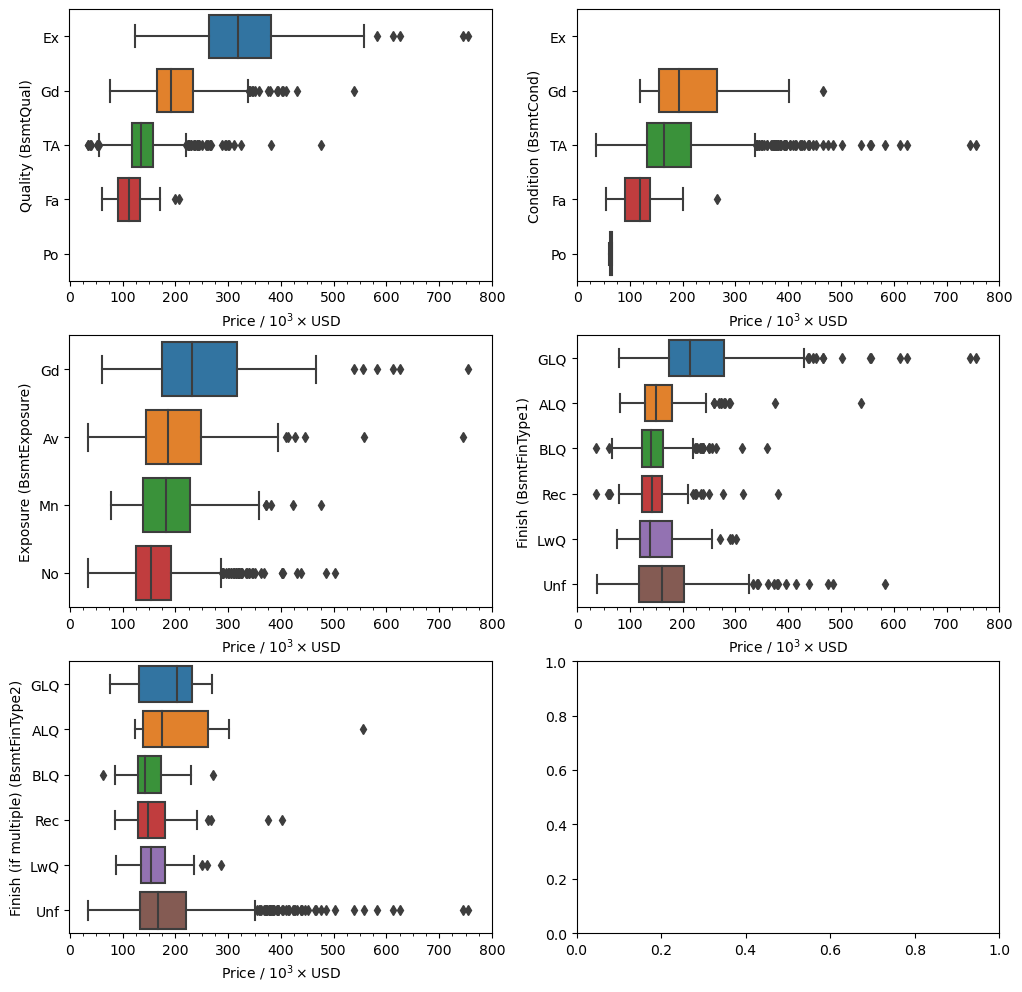

In [45]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=2)
ax = ax.flatten()
cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
labels = ['Quality', 'Condition', 'Exposure', 'Finish', 'Finish (if multiple)']
orders = dict(BsmtQual=['Ex', 'Gd', 'TA', 'Fa', 'Po'],
              BsmtCond=['Ex', 'Gd', 'TA', 'Fa', 'Po'],
              BsmtExposure=['Gd', 'Av', 'Mn', 'No'],
              BsmtFinType1=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'],
              BsmtFinType2=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'])
for i, (col, label) in enumerate(zip(cols, labels)):
    sns.boxplot(x='SalePrice', y=col, data=df, ax=ax[i],
                order=orders[col])
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(2.5e4))
    ticks = np.arange(0, 9e5, 1e5)
    labels = [str(int(round(t/1e3,0))) for t in ticks]
    ax[i].set_xticks(ticks, labels)
    ax[i].set_xlabel('Price / 10$^3\\times$USD')
    ax[i].set_ylabel(label+f' ({col})')

What we can see here is that there is a stronger correlation between the
sale price of a house and the basement quality (`'BsmtQual'`) and condition
(`'BsmtCond'`) than with the other categorical features. From before we are
missing values in the `'BsmtExposure'` and `'BsmtFinType2'` features, but
we have already seen that they should not be missing. Based on what I see
on the plots above I believe it is safe to replace the missing values for
the two rows with an imputed value based on the mode of the column with
respect to the neighborhood the house is in and the type of dwelling.
Before we do so let's make sure that this will actually make sense.

Here's the data for the row missing the `'BsmtExposure'` value.

In [46]:
df.loc[(df['BsmtExposure'].isnull()) & (~df['BsmtCond'].isnull()),
       [x for x in df.columns if 'bsmt' in x.lower()]+['Neighborhood', 'MSSubClass']].T

Id,949
BsmtQual,Gd
BsmtCond,TA
BsmtExposure,NaN
BsmtFinType1,Unf
BsmtFinSF1,0
BsmtFinType2,Unf
BsmtFinSF2,0
BsmtUnfSF,936
TotalBsmtSF,936
BsmtFullBath,0


A breakdown of the basement exposure for each dwelling type in the
College Creek (`'CollgCr'`) neighborhood.

In [47]:
df.groupby(['Neighborhood', 'MSSubClass'])['BsmtExposure'].value_counts(dropna=False).loc['CollgCr']

MSSubClass  BsmtExposure
120         Av               7
            Gd               2
            Mn               1
20          Av              35
            No              32
            Gd               8
            Mn               6
60          No              33
            Av              11
            Mn               7
            NaN              1
            Gd               1
80          Av               2
            Gd               1
85          Av               3
Name: count, dtype: int64

We know that our missing row has the label `'60'` for the dwelling type
and we see that the mode is that there is no exposure. I believe this
is a fair enough assumption given that this is a 2 story home. So
let's make the replacement in a generalized fashion with the transform
method in pandas.

**Some of the potential pitfalls of this type of replacement is that if the
mode of the data is actually `NaN` then you may end up just replacing
a `NaN` value with another `NaN` value.**

In [48]:
df['BsmtExposure'] = df.groupby(['Neighborhood', 'MSSubClass'])['BsmtExposure'].transform(fill_mode)

And now let's look at the other problematic column, `'BsmtFinType2'`.

Here is the data in the missing row.

In [49]:
df.loc[(df['BsmtFinType2'].isnull()) & (~df['BsmtCond'].isnull()),
       [x for x in df.columns if 'bsmt' in x.lower()]+['Neighborhood', 'MSSubClass']].T

Id,333
BsmtQual,Gd
BsmtCond,TA
BsmtExposure,No
BsmtFinType1,GLQ
BsmtFinSF1,1124
BsmtFinType2,NaN
BsmtFinSF2,479
BsmtUnfSF,1603
TotalBsmtSF,3206
BsmtFullBath,1


In [50]:
df.groupby(['Neighborhood', 'MSSubClass'])['BsmtFinType2'].value_counts(dropna=False).loc['NridgHt']

MSSubClass  BsmtFinType2
120         Unf             19
160         Unf              3
20          Unf             30
            ALQ              1
            NaN              1
60          Unf             23
Name: count, dtype: int64

So most of the houses actually don't have a second type of finished basement, or it's `'Unf'`.

Let's see what are the values for the `'BsmtFinType2'` when the `'BsmtFinSF2'` is greater than zero.

In [51]:
df.loc[df['BsmtFinSF2'] > 0].groupby('MSSubClass').get_group('20')['BsmtFinType2'].value_counts()

BsmtFinType2
Rec    29
LwQ    28
BLQ    17
ALQ     7
GLQ     5
Name: count, dtype: int64

And we see that the data should have a value that is not `'Unf'`.

The problem with this row is that the mode for the finish type and the type of dwelling
is actually unfinished, `'Unf'`, which would create a contradiction in the data. Since it is just
one row I will actually drop it. In the grand scheme of things keeping this one row will
not result in a large change in the final results.

In [52]:
df.drop([333], inplace=True)

In [53]:
missing_vals(df)

,count,percent
PoolQC,1451,99.588195
MiscFeature,1403,96.293754
Alley,1366,93.754290
Fence,1176,80.713795
FireplaceQu,690,47.357584
LotFrontage,259,17.776253
GarageType,81,5.559369
GarageYrBlt,81,5.559369
GarageFinish,81,5.559369
GarageQual,81,5.559369


And we have eliminated all missing data points pertaining to the basement.

## Garage

Here, I want to figure out the features pertaining to information on the garage.
The values from the description file are.

<pre>
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
</pre>

Let's first take a look at the current state of the columns data.

In [54]:
missing_vals(df).loc[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']]

,count,percent
GarageType,81,5.559369
GarageYrBlt,81,5.559369
GarageFinish,81,5.559369
GarageQual,81,5.559369
GarageCond,81,5.559369


We see that the features that are missing data are all categorical features except
for `'GarageYrBlt'` which is for when the garage was built. However, if there is no
garage then there will obviously be no year for when the garage was built.

First I want to make sure that where there is missing data the numerical values
make sense.

In [55]:
df.loc[df['GarageType'].isnull(), [x for x in df.columns if 'garage' in x.lower()]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0           0           NaN         NaN           81
Name: count, dtype: int64

And clearly we see that when the categorical data is missing a value the numerical
value for `'GarageCars'` and `'GarageArea'` is 0. For the categorical data this is
a simple replacement and we will replace all `Nan` with `'None'`.

In [56]:
cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[cat_cols] = df[cat_cols].fillna('None')

For `'GarageYrBlt'` we do not have a nice and neat value that we can asign that
makes complete sense. In a way we can set the value to 0 and force it to be an
outlier. It can become an interesting thought experiment to try to reason what
can happen to the model when do this as opposed to setting the value to some kind
of mean based on where the house is located. Could it be that
by setting the values to 0 will it affect the correlation between the sale price
and the year the garage was built or if there is a garage at all.

Let's look at that really quick. Here is the correlation between sale price and
garage year before replacing the missing values.

In [57]:
df.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.4867053251422345

And if we replace the missing values with 0.

In [58]:
df_tmp = df.copy()
df_tmp['GarageYrBlt'] = df_tmp['GarageYrBlt'].fillna(0)
df_tmp.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.2613300869851237

And if we replace the missing values with 100.

In [59]:
df_tmp = df.copy()
df_tmp['GarageYrBlt'] = df_tmp['GarageYrBlt'].fillna(100)
df_tmp.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.26261306587279576

And if we replace the missing values with 1000.

In [60]:
df_tmp = df.copy()
df_tmp['GarageYrBlt'] = df_tmp['GarageYrBlt'].fillna(1000)
df_tmp.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.28550228706456937

And if we replace the missing values with 1900.

In [61]:
df_tmp = df.copy()
df_tmp['GarageYrBlt'] = df_tmp['GarageYrBlt'].fillna(1900)
df_tmp.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.5185149371069989

And if we were to replace the missing values with some average with respect to the neighborhood.

In [62]:
df_tmp = df.copy()
df_tmp['GarageYrBlt'] = df_tmp.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x: x.fillna(x.mean()))
df_tmp.corr(numeric_only=True).loc['GarageYrBlt', 'SalePrice']

0.5000940244955719

I believe this is actually a peculiar problem that requires some careful consideration.
We can't just make the year a garage was built to be the average when it does not exist
and is it also good to create these outliers in the data set? Well, yes actually, because
it can be said that the absence of a garage is actually having a very small effect on
the sale price owing to a small correlation value between them. It will be interesting
to actually create a few models to see the actual effect on the final results.

For now let's just set them to 0.

In [63]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [64]:
missing_vals(df)

,count,percent
PoolQC,1451,99.588195
MiscFeature,1403,96.293754
Alley,1366,93.754290
Fence,1176,80.713795
FireplaceQu,690,47.357584
LotFrontage,259,17.776253


And we no longer have any values pertaining to the garage.

## Pool quality, Alley, Fence, Misc Feature

Let's quickly take care of the pool quality, alley, and fence values as
we already know they should be `'None'` when there are missing values.
As alwys I just like to be careful where I can and cross check with data
that is related in the data set already. This can only be done for the
`'PoolQC'`, and `'MiscFeature'` data.

In [65]:
df.loc[df['PoolQC'].isnull(), ['PoolArea', 'PoolQC']].value_counts(dropna=False)

PoolArea  PoolQC
0         NaN       1451
Name: count, dtype: int64

In [66]:
df.loc[df['MiscFeature'].isnull(), ['MiscVal', 'MiscFeature']].value_counts(dropna=False)

MiscVal  MiscFeature
0        NaN            1403
Name: count, dtype: int64

In [67]:
df.loc[df['FireplaceQu'].isnull(), ['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            690
Name: count, dtype: int64

And now that we have confirmed that when `'PoolQC'` is missing a value the
value for `'PoolArea'` is 0, we make the replacement.

In [68]:
cat_cols = ['PoolQC', 'Alley', 'Fence', 'MiscFeature', 'FireplaceQu']
df[cat_cols] = df[cat_cols].fillna('None')

In [69]:
missing_vals(df)

,count,percent
LotFrontage,259,17.776253


## Lot Frontage

And we are left with dealing with missing values for the lot frontage. Here is the
description for the feature.

<pre>
LotFrontage: Linear feet of street connected to property
</pre>

For this value we will have to go through different values and make an attempt to
guess based on other values. So let's first look at the correlation metrics as
this will be a good starting point to see what values are connected.

In [70]:
df.corr(numeric_only=True)['LotFrontage'].sort_values(key=abs, ascending=False).head(8)

LotFrontage     1.000000
1stFlrSF        0.406596
LotArea         0.388597
SalePrice       0.370210
GrLivArea       0.355398
TotRmsAbvGrd    0.336123
TotalBsmtSF     0.323647
GarageArea      0.322424
Name: LotFrontage, dtype: float64

Text(0, 0.5, 'Lot Frontage / ft')

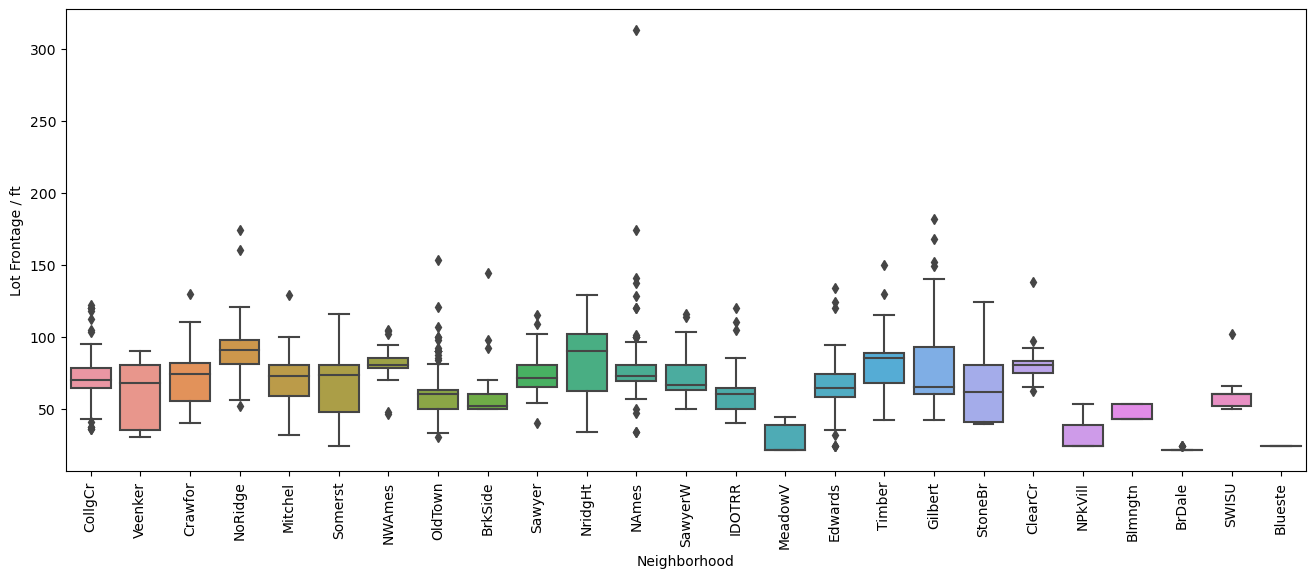

In [71]:
plt.figure(figsize=(16,6), dpi=100)
sns.boxplot(y='LotFrontage', x='Neighborhood', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

Text(0, 0.5, 'Lot Frontage / ft')

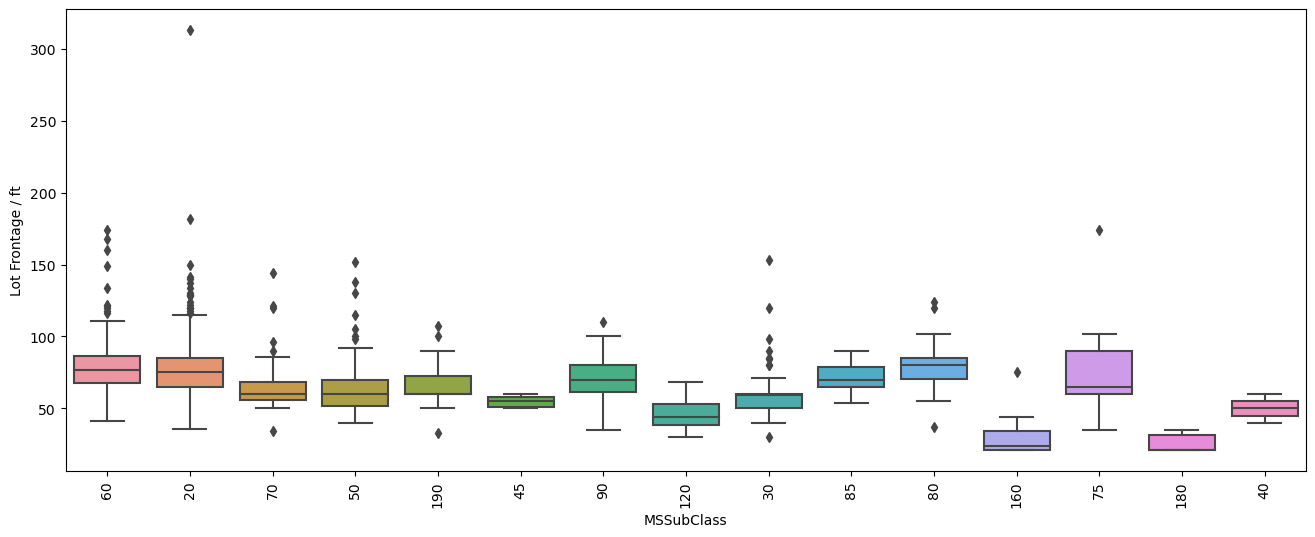

In [72]:
plt.figure(figsize=(16,6), dpi=100)
sns.boxplot(y='LotFrontage', x='MSSubClass', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

Text(0, 0.5, 'Lot Frontage / ft')

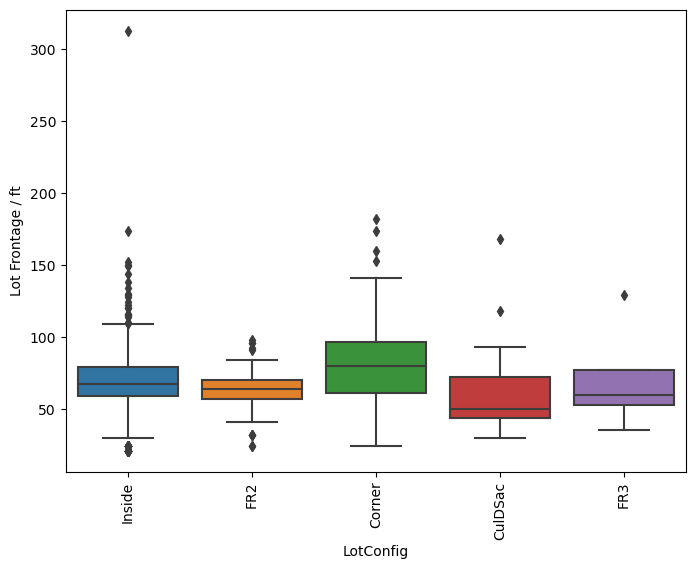

In [73]:
plt.figure(figsize=(8,6), dpi=100)
sns.boxplot(y='LotFrontage', x='LotConfig', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

Text(0, 0.5, 'Lot Frontage / ft')

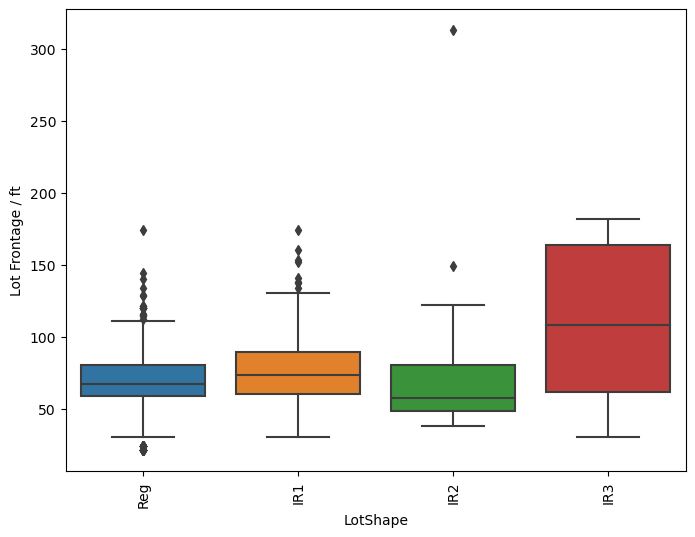

In [74]:
plt.figure(figsize=(8,6), dpi=100)
sns.boxplot(y='LotFrontage', x='LotShape', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

Text(0, 0.5, 'Lot Frontage / ft')

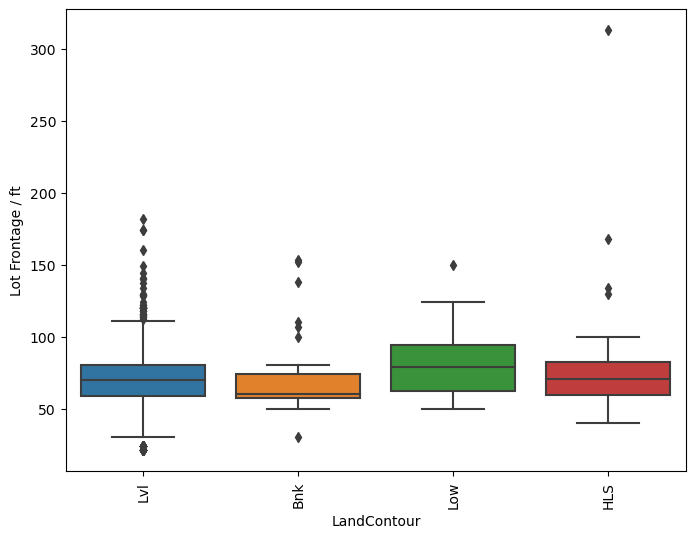

In [75]:
plt.figure(figsize=(8,6), dpi=100)
sns.boxplot(y='LotFrontage', x='LandContour', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

Text(0, 0.5, 'Lot Frontage / ft')

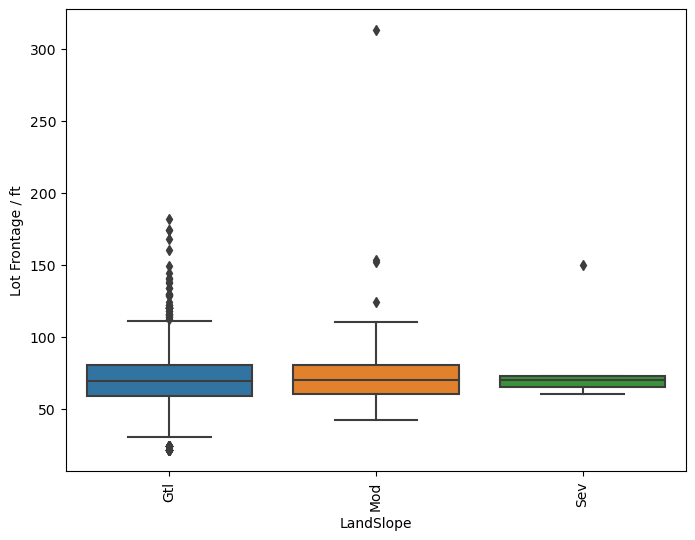

In [76]:
plt.figure(figsize=(8,6), dpi=100)
sns.boxplot(y='LotFrontage', x='LandSlope', data=df, orient='vertical')
plt.xticks(rotation=90)
plt.ylabel('Lot Frontage / ft')

<Axes: xlabel='LotFrontage', ylabel='1stFlrSF'>

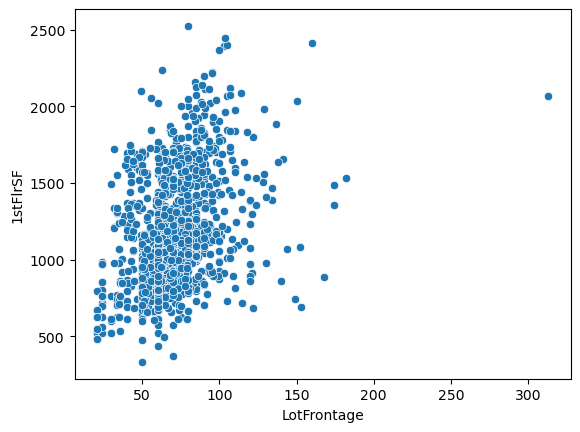

In [77]:
sns.scatterplot(x='LotFrontage', y='1stFlrSF', data=df)

<Axes: xlabel='LotFrontage', ylabel='LotArea'>

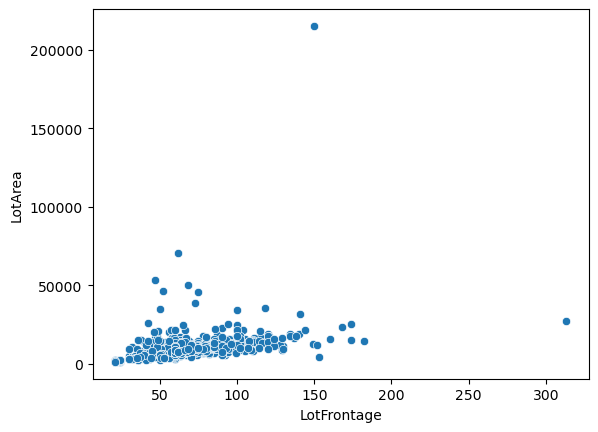

In [78]:
sns.scatterplot(x='LotFrontage', y='LotArea', data=df)

In [79]:
df.loc[df['LotArea'] > 200e3]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
314,20,RL,150.0,215245,Pave,None,IR3,Low,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Normal,375000


In [80]:
df.loc[df['LotFrontage'] > 300]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
935,20,RL,313.0,27650,Pave,None,IR2,HLS,AllPub,Inside,...,0,None,None,None,0,11,2008,WD,Normal,242000


<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

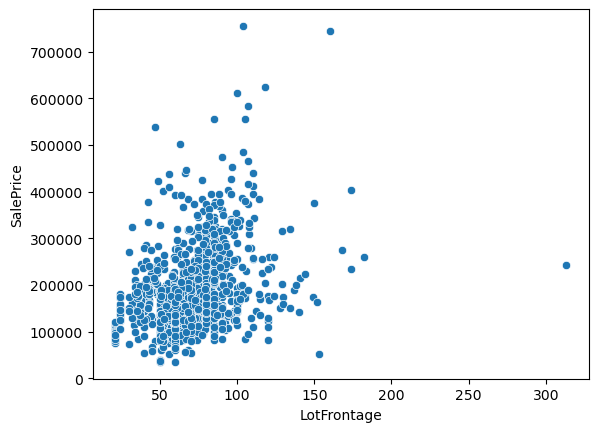

In [81]:
sns.scatterplot(x='LotFrontage', y='SalePrice', data=df)

So what do we see from all these plots?

Well the first one comparing the distribution of lot frontage values as a function of the
neighborhood does not show a lot of variation between the values. In some neighborhoods
the distribution seems to be smaller, in others there are less points that fall outside
of the $1.5\times \text{IQR}$ limits set by Seaborn in the box plots. Same applies to the
next plot with dwelling types, `'MSSubClass'`. It's not until we get to comparing the
values of lot area and lot frontage that we get a good linear trend between the two
values with exception of two outliers.

Based on this I will use a linear interpolation to fill in the missing values for the
`'LotFrontage'` column.

In [82]:
def func(x, a, b):
    return a*x+b
tmp = df.loc[(df['LotArea'] < 200e3) & (df['LotFrontage'] < 300)][['LotArea', 'LotFrontage']]
popt, pcov = curve_fit(f=func, xdata=tmp['LotArea'].values, ydata=tmp['LotFrontage'].values)

Before we make the replacement lets take a look at how the line fit looks.

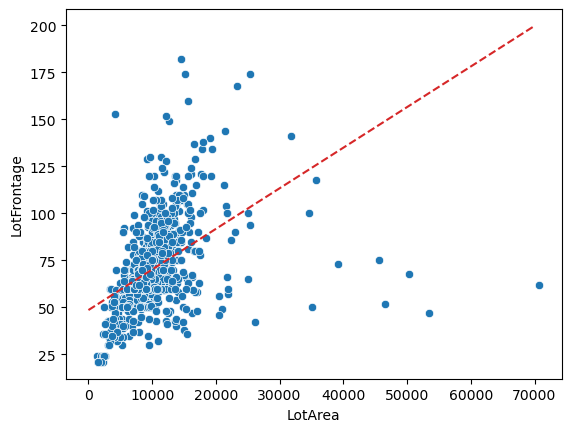

In [83]:
sns.scatterplot(y='LotFrontage', x='LotArea', data=tmp)
x = np.linspace(0, 70e3, 20)
plt.plot(x, func(x, *popt), color='tab:red', linestyle='--')

That's a pretty terrible fit. Due to this issue we will have to use another method to
impute the values.

Based on the previous plots we see that there is a small dependence on the lot frontage
values on which neighborhood we are in. So let's take a look at the averages that we can
get only from the neighborhoods and try to mix it up invloving the type of dwelling
`'MSSubClass'`, lot configuration `'LotConfig'`, or `'LotShape'`.

<Axes: xlabel='SalePrice', ylabel='LotFrontage'>

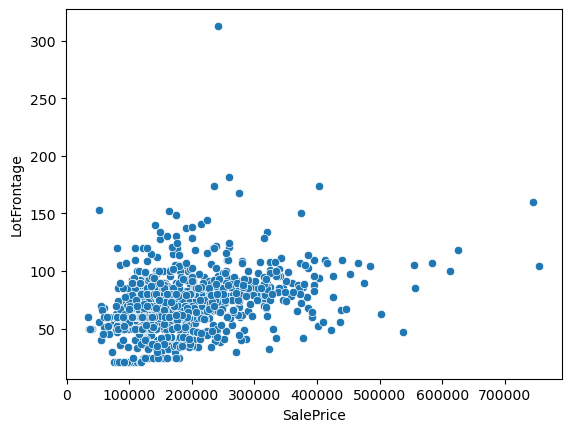

In [84]:
sns.scatterplot(y='LotFrontage', x='SalePrice', data=df)

Group by the `'Neighborhood'` column and transform missing values (orange markers) with the average or median.

Missing values after average: 0
Missing values after median: 0


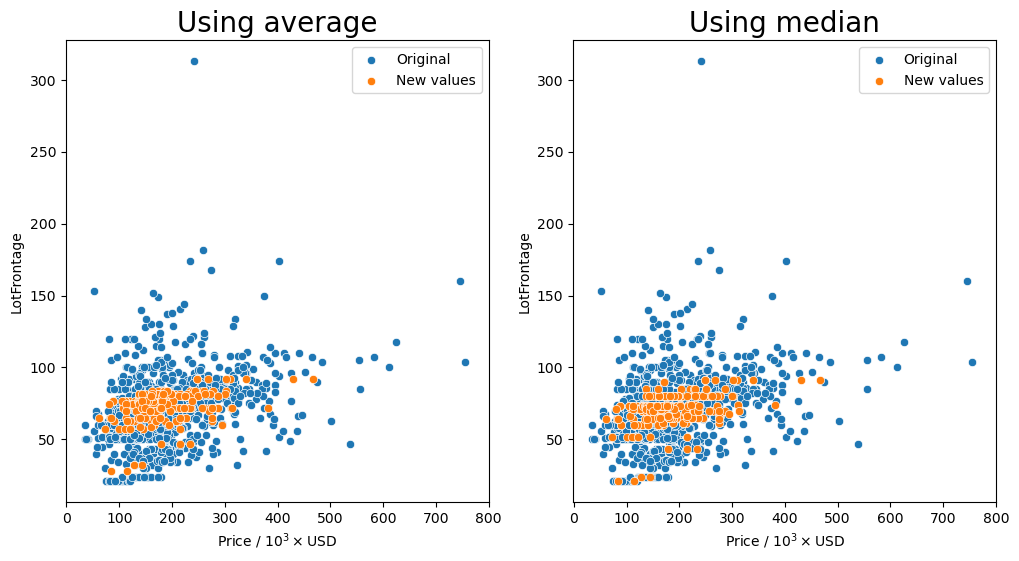

In [85]:
gen_lotfront_plot(df, 'Neighborhood')

Group by the `'Neighborhood'`, `'MSSubClass'`, and `'MSZoning'` columns and
transform missing values (orange markers) with the average or median.

Missing values after average: 11
Missing values after median: 11


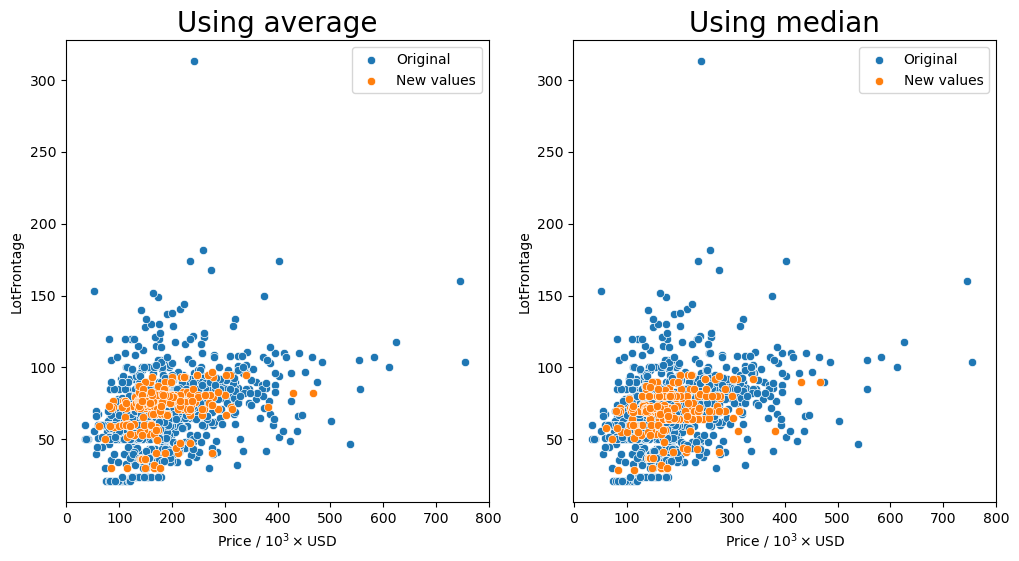

In [86]:
gen_lotfront_plot(df, ['Neighborhood', 'MSSubClass', 'MSZoning'])

Group by the `'LontConfig'`, and `'LotShape'` columns and transform
missing values (orange markers) with the average or median.

Missing values after average: 1
Missing values after median: 1


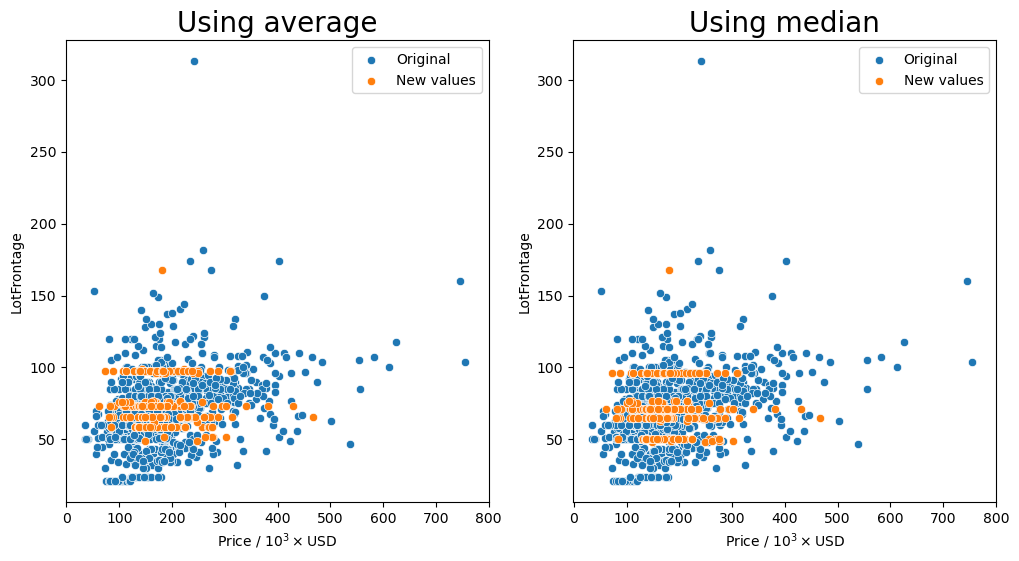

In [87]:
gen_lotfront_plot(df, ['LotConfig', 'LotShape'])

Group by the `'Neighborhood'`, `'LontConfig'`, and `'LotShape'` columns and transform
missing values (orange markers) with the average or median.

Missing values after average: 33
Missing values after median: 33


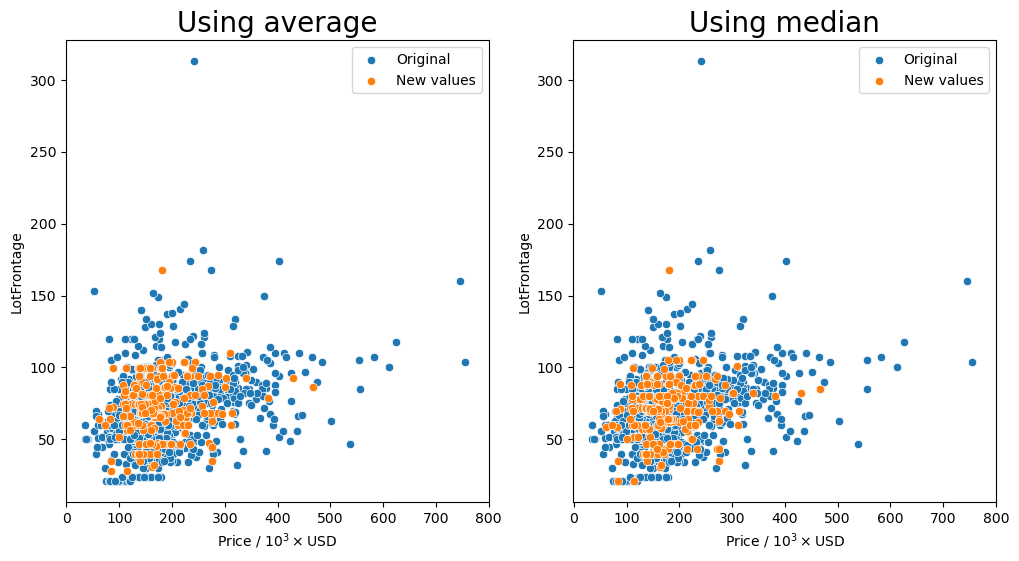

In [88]:
gen_lotfront_plot(df, ['LotConfig', 'LotShape', 'Neighborhood'])

Group by the `'LandContour'`, and `'LotShape'` columns and transform missing
values (orange markers) with the average or median.

Missing values after average: 0
Missing values after median: 0


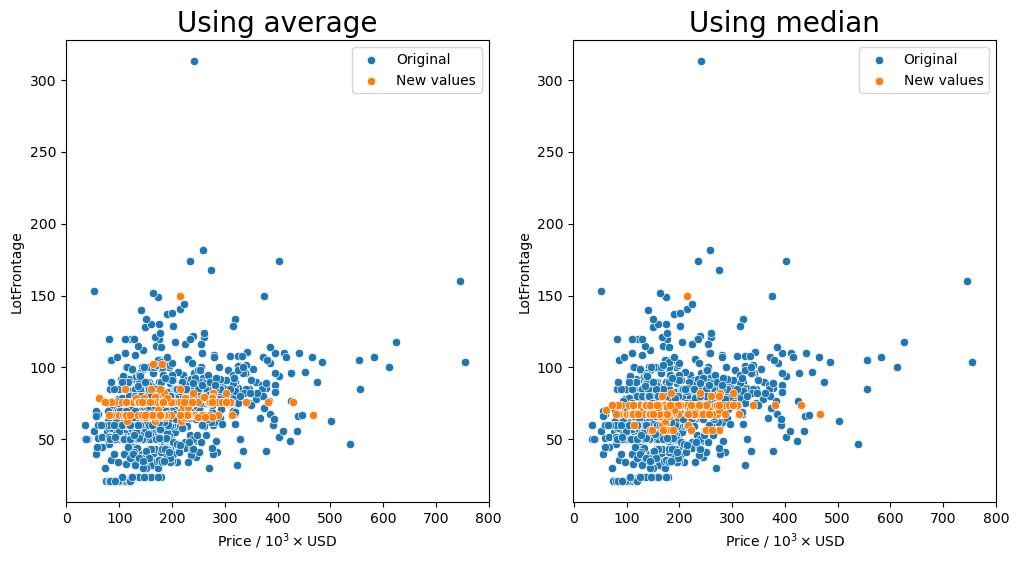

In [89]:
gen_lotfront_plot(df, ['LandContour', 'LotShape'])

Group by the `'Neighborhood'`, `'LandContour'`, and `'LotShape'` columns and
transform missing values (orange markers) with the average or median.

Missing values after average: 21
Missing values after median: 21


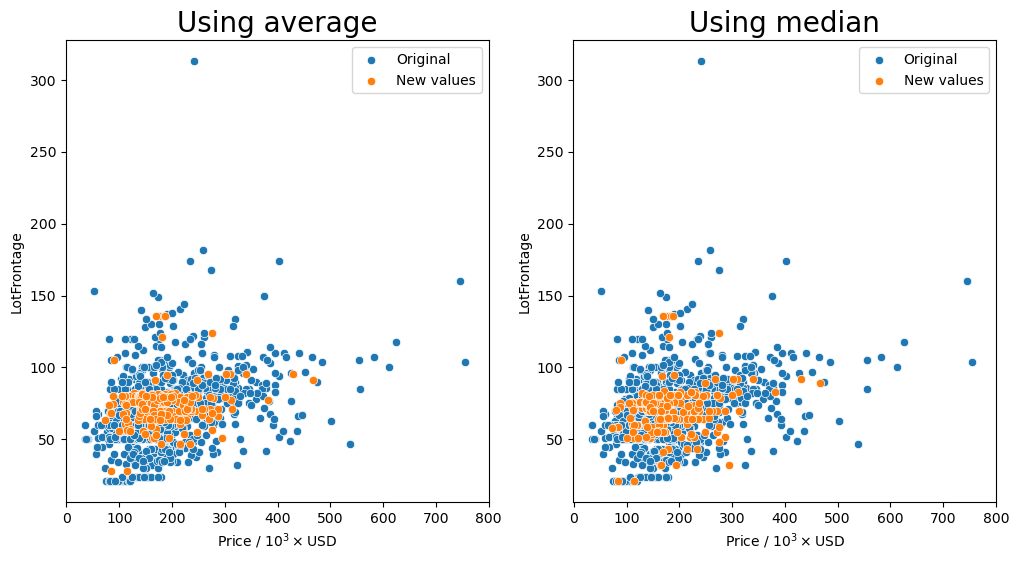

In [90]:
gen_lotfront_plot(df, ['LandContour', 'LotShape', 'Neighborhood'])

It seems that for most of the combinations that we tried for how to group
the values, having the `'Neighborhood'` column in the group seemed to keep
the resulting values fairly consistent as shown by the orange markers. We
see that they are spread out throughout the entire middle section with most
of the other data points.

So the question remains, *which is the best method?* Just transforming the
missing values in the data set with the average for each neighborhood seems
to behave well enough as we have seen that there is a small dependence on
the lot frontage and the neighborhood. However, I would argue that the shape
and the configuration of the lot are equally as important. We can see in the
box plots that the distribution of lot frontage values with respect to the
lot configuration (`'LotConfig'`) and lot shape (`'LotShape'`) does vary from
one to the other. The `'IR3'` values in `'LotShape'` have a very wide
distribution and it makes sense to separate those values from the rest as it
can affect the average that is calculated.

As always this is mainly just an educated guess on what is the best method to
deal with the missing numerical values. I believe that this method tries to
take many different parameters that can affect the lot frontage value and gives
a more realistic value. You will always have outliers, but I think this is the
best that we can some up with.

So I will make the replacement of the missing values with a transformed average
after grouping by `'Neighborhood'`, `'LotConfig'`, and `'LotShape'`.
But, there is one **big** issue
with this. There are still missing values in the `'LotFrontage'` column
meaning that there are not enough data points in the groups to calculate the
average this way. Seeing as grouping by just the `'Neighborhood'` fills in all
the missing values, I will just group by the `'Neighborhood'` column and
fill in the calculated average.

In [91]:
group_cols = ['Neighborhood']
df['LotFrontage'] = df.groupby(group_cols)['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [92]:
missing_vals(df)

,count,percent


And we are done replacing all of the missing values in the data set
and can start to actually use it for predictions!!

In [95]:
df_objs = df.select_dtypes(include='object')
df_nums = df.select_dtypes(exclude='object')

In [98]:
df_objs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 1 to 1460
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1457 non-null   object
 1   MSZoning       1457 non-null   object
 2   Street         1457 non-null   object
 3   Alley          1457 non-null   object
 4   LotShape       1457 non-null   object
 5   LandContour    1457 non-null   object
 6   Utilities      1457 non-null   object
 7   LotConfig      1457 non-null   object
 8   LandSlope      1457 non-null   object
 9   Neighborhood   1457 non-null   object
 10  Condition1     1457 non-null   object
 11  Condition2     1457 non-null   object
 12  BldgType       1457 non-null   object
 13  HouseStyle     1457 non-null   object
 14  RoofStyle      1457 non-null   object
 15  RoofMatl       1457 non-null   object
 16  Exterior1st    1457 non-null   object
 17  Exterior2nd    1457 non-null   object
 18  MasVnrType     1457 non-null   ob

In [99]:
df_nums.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 1 to 1460
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1457 non-null   float64
 1   LotArea        1457 non-null   int64  
 2   OverallQual    1457 non-null   int64  
 3   OverallCond    1457 non-null   int64  
 4   YearBuilt      1457 non-null   int64  
 5   YearRemodAdd   1457 non-null   int64  
 6   MasVnrArea     1457 non-null   float64
 7   BsmtFinSF1     1457 non-null   int64  
 8   BsmtFinSF2     1457 non-null   int64  
 9   BsmtUnfSF      1457 non-null   int64  
 10  TotalBsmtSF    1457 non-null   int64  
 11  1stFlrSF       1457 non-null   int64  
 12  2ndFlrSF       1457 non-null   int64  
 13  LowQualFinSF   1457 non-null   int64  
 14  GrLivArea      1457 non-null   int64  
 15  BsmtFullBath   1457 non-null   int64  
 16  BsmtHalfBath   1457 non-null   int64  
 17  FullBath       1457 non-null   int64  
 18  HalfBath     

In [100]:
df_objs = pd.get_dummies(df_objs, drop_first=True)

In [104]:
final_df = pd.concat([df_nums, df_objs], axis=1)

In [106]:
final_df.to_csv(os.path.join('data', 'ames-data-no-missing.csv'))